In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
train_dataset = coco.CocoDataSet('./COCO2017/', 'val',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(800, 1024))

train_generator = data_generator.DataGenerator(train_dataset)


loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


#### display a sample

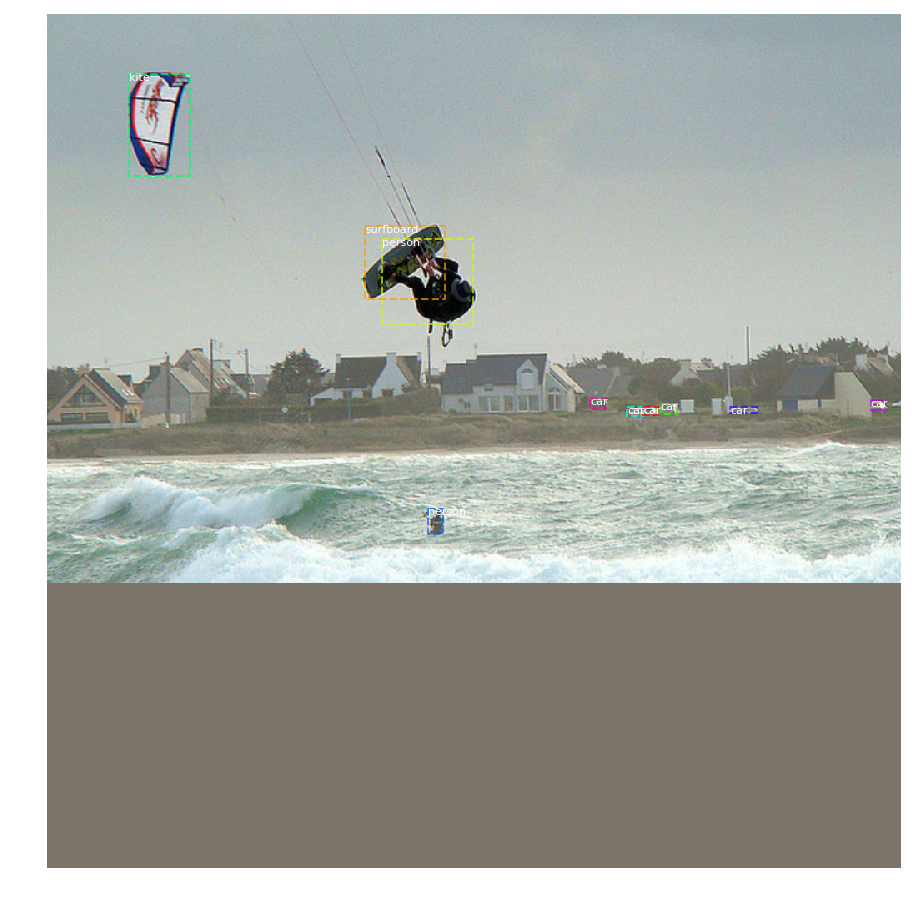

In [5]:
from detection.datasets.utils import get_original_image
img, img_meta, bboxes, labels = train_dataset[0]

rgb_img = np.round(img + img_mean)
ori_img = get_original_image(img, img_meta, img_mean)

visualize.display_instances(rgb_img, bboxes, labels, train_dataset.get_categories())

#### load model

In [6]:
from detection.models.detectors import faster_rcnn

model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()))

In [7]:
batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))

In [8]:
_ = model((batch_imgs, batch_metas), training=False)

In [9]:
model.load_weights('weights/faster_rcnn.h5', by_name=True)

In [10]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)

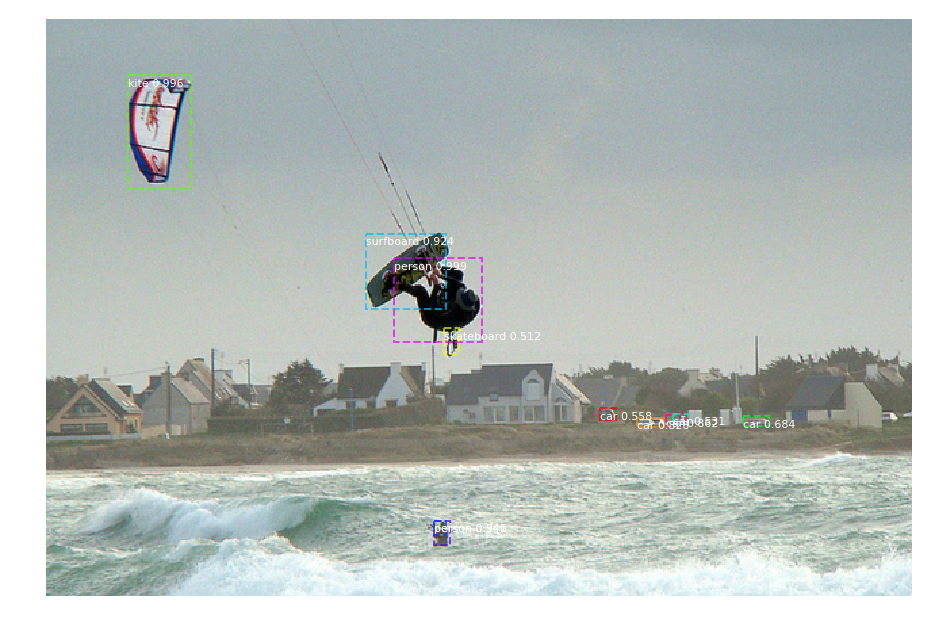

In [11]:
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### overfit a sample

In [12]:
optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True)


batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))
batch_bboxes = tf.Variable(np.expand_dims(bboxes, 0))
batch_labels = tf.Variable(np.expand_dims(labels, 0))

for batch in range(100):
    with tf.GradientTape() as tape:
        rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
            model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

        loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print('batch', batch, '-', loss_value.numpy())

Instructions for updating:
Use tf.identity instead.
batch 0 - 1.5021714
batch 1 - 0.91936684
batch 2 - 0.6515306
batch 3 - 0.5800308
batch 4 - 0.46373314
batch 5 - 0.40056598
batch 6 - 0.38077024
batch 7 - 0.35134074
batch 8 - 0.33353412
batch 9 - 0.32375196
batch 10 - 0.31190133
batch 11 - 0.2554204
batch 12 - 0.25305206
batch 13 - 0.26450133
batch 14 - 0.24498151
batch 15 - 0.18703522
batch 16 - 0.2144177
batch 17 - 0.17433697
batch 18 - 0.16092639
batch 19 - 0.15375957
batch 20 - 0.1545969
batch 21 - 0.15241703
batch 22 - 0.17152163
batch 23 - 0.14584096
batch 24 - 0.1403253
batch 25 - 0.11825122
batch 26 - 0.10345548
batch 27 - 0.09716025
batch 28 - 0.08890823
batch 29 - 0.13330819
batch 30 - 0.095457934
batch 31 - 0.111193895
batch 32 - 0.096846096
batch 33 - 0.08933622
batch 34 - 0.076706916
batch 35 - 0.0818037
batch 36 - 0.08717659
batch 37 - 0.08904894
batch 38 - 0.081356935
batch 39 - 0.092906
batch 40 - 0.08707836
batch 41 - 0.074252166
batch 42 - 0.09128922
batch 43 - 0.086

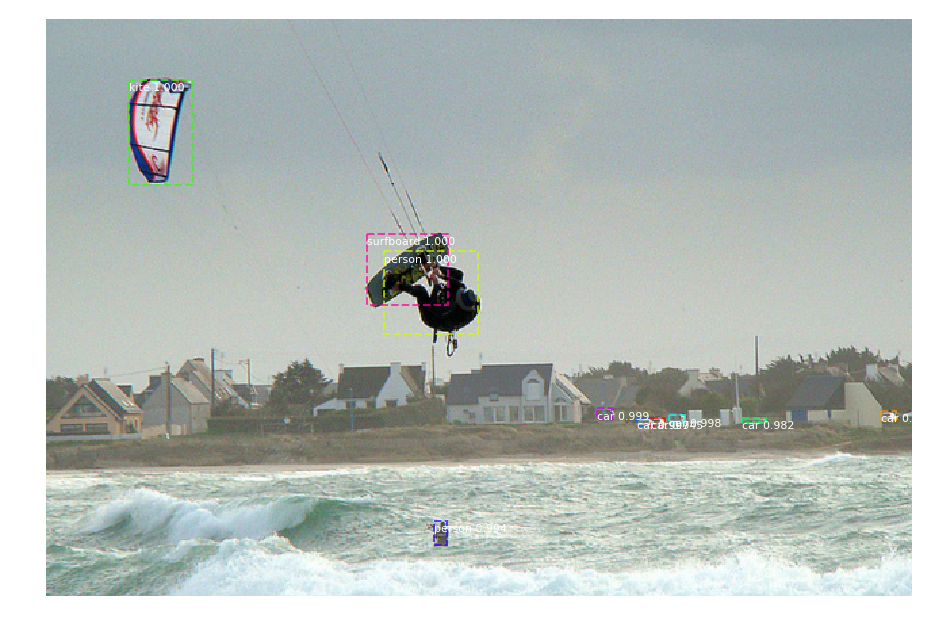

In [13]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### use tf.data

In [ ]:
batch_size = 1

train_tf_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))
train_tf_dataset = train_tf_dataset.padded_batch(
    batch_size, padded_shapes=([None, None, None], [None], [None, None], [None]))
train_tf_dataset = train_tf_dataset.prefetch(100).shuffle(100)

#### train model

In [ ]:
optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True)

epochs = 20

for epoch in range(epochs):

    loss_history = []
    for (batch, inputs) in enumerate(train_tf_dataset):
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        loss_history.append(loss_value.numpy())
        
        if batch % 100 == 0:
            print('epoch:', epoch, ', batch:', batch, ', loss:', np.mean(loss_history))